In [102]:
import os
import sys
import numpy as np
import pandas as pd
import pickle
import random
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.metrics import hinge_loss
from AEspeech import AEspeech
import pdb
from sklearn import metrics
from sklearn import svm, datasets
from sklearn.svm import SVC
from scipy import stats
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import joblib

In [244]:
#load results for model type and speech representation type (aggregated and per utterance) as well as mfda scores

PATH=os.getcwd()

mod="CAE"
rep='broadband'
aggResultsPath=PATH+"/pdSpanish/classResults/svm/"+mod+'_'+rep+'_aggResults.pkl'
aggResults=pd.read_pickle(aggResultsPath)
# results_path=PATH+"/pdSpanish/classResults/svm/"+mod+'_'+rep+'Results.pkl'
# results=pd.read_pickle(results_path)
earlyFuseResultsPath=PATH+"/pdSpanish/classResults/svm/"+mod+'_earlyFusionResults.pkl'
efResults=pd.read_pickle(earlyFuseResultsPath)

wvlt_earlyFuseResultsPath=PATH+"/pdSpanish/classResults/svm/"+mod+'_wvlt_earlyFusionResults.pkl'
wvlt_efResults=pd.read_pickle(wvlt_earlyFuseResultsPath)

lateFuseResultsPath=PATH+"/pdSpanish/classResults/svm/"+mod+'_lateFusionResults.pkl'
lfResults=pd.read_pickle(lateFuseResultsPath)

wvlt_lateFuseResultsPath=PATH+"/pdSpanish/classResults/svm/"+mod+'_wvlt_lateFusionResults.pkl'
wvlt_lfResults=pd.read_pickle(wvlt_lateFuseResultsPath)

mfda_path=PATH+"/pdSpanish/"
mfdas=pd.read_csv(mfda_path+"metadata-Spanish_All.csv")['M-FDA'].values
pd_mfdas=mfdas[0:50]
hc_mfdas=mfdas[50:]


# aggResults=efResults
# rep='early fusion - narrowband/broadband'

# aggResults=wvlt_efResults
# rep='early fusion - narrowband/broadband/wvlt'

# aggResults=lfResults
# rep='late fusion - narrowband/broadband'

# aggResults=wvlt_lfResults
# rep='late fusion - narrowband/broadband/wvlt'

In [245]:
num_itrs=max(aggResults['Data']['bin_class'].keys())+1
sdAggResults=np.zeros((100,num_itrs,aggResults['Data']['bin_class'][0][0].shape[0],aggResults['Data']['bin_class'][0][0].shape[1]))
avgAggResults={spk:{num[i]:[] for num in zip(range(50),range(50,100))} for i,spk in enumerate(['pd','hc'])}
mfdaResults=np.zeros(100)

for j in range(num_itrs):
    for i in range(100):
        sdAggResults[i,j,:,:]=aggResults['Data']['bin_class'][j][i]
        
        if j==0:
            mfdaResults[i]=np.median(list(aggResults['Data']['mFDA_spear_corr'][j][i].values()))*(1/num_itrs)
            if i<50:
                avgAggResults['pd'][i]=aggResults['Data']['bin_class'][j][i]*(1/num_itrs)
            else:
                avgAggResults['hc'][i]=aggResults['Data']['bin_class'][j][i]*(1/num_itrs)
        else:
            mfdaResults[i]+=np.median(list(aggResults['Data']['mFDA_spear_corr'][j][i].values()))*(1/num_itrs)
            if i<50:
                avgAggResults['pd'][i]+=aggResults['Data']['bin_class'][j][i]*(1/num_itrs)
            else:
                avgAggResults['hc'][i]+=aggResults['Data']['bin_class'][j][i]*(1/num_itrs)

In [246]:
test_acc=0
y_score=np.zeros((100,2))
y_score_curr=y_score
y_test=np.zeros((100,2))
y_test_curr=y_test
max_acc=0
thresh=-0.04
for i in range(100):
    if i<50:
        y_score[i,:]=np.median(avgAggResults['pd'][i][:,0]),np.median(avgAggResults['pd'][i][:,1])
        y_test[i,:]=np.vstack((np.zeros(1),np.ones(1))).T
        spk_diff=y_score[i,1]-y_score[i,0]
        if spk_diff>thresh:
            test_acc+=1
    else:
        y_score[i,:]=np.median(avgAggResults['hc'][i][:,0]),np.median(avgAggResults['hc'][i][:,1])
        y_test[i,:]=np.vstack((np.ones(1),np.zeros(1))).T
        spk_diff=y_score[i,1]-y_score[i,0]
        if spk_diff<thresh:
            test_acc+=1
        

Text(0.5, 1.0, 'm-FDA v. Difference in Classification Probability\nCAE, broadband\nOverall Test Acc: 0.72\n$\\rho$ = 0.56')

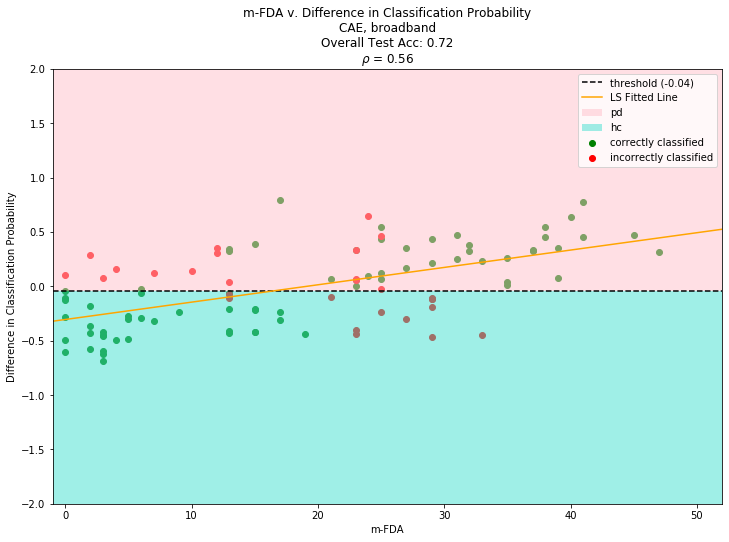

In [247]:
# """Plots predicted probability of correct class. (ostensibly, greater than 0.5 implies correct class.)"""
# correct_idx=np.where(np.concatenate((y_score[0:50,1],y_score[50:,0]))>.5)
# incorrect_idx=np.where(np.concatenate((y_score[0:50,1],y_score[50:,0]))<.5)
# plt.scatter(mfdas[correct_idx],np.concatenate((y_score[0:50,1],y_score[50:,0]))[correct_idx])
# plt.scatter(mfdas[incorrect_idx],np.concatenate((y_score[0:50,1],y_score[50:,0]))[incorrect_idx] )
# plt.axhline(y=0.5, color='black', linestyle='--')
# plt.axhspan(0.5, 1.1, color='green', alpha=0.5, lw=0)
# plt.axhspan(-.1, 0.5, color='red', alpha=0.5, lw=0)
# plt.legend(['threshold (0.5)', 'correctly classified', 'incorrectly classified'])
# plt.xlim([-1,55])
# plt.ylim([0,1])
# plt.xlabel('m-FDA')
# plt.ylabel('Predicted Probability of Correct Class')
# plt.title('Predicted Probability of Correct Classification v. m-FDA\nOverall Test Acc: '+str(len(correct_idx[0])/100)+' \n'+mod+", "+rep)

"""Prediction based on difference between predicted class probs."""
plt.figure(figsize=(12,8))
poly=np.polyfit(mfdas, y_score[:,1]-y_score[:,0], 1)
x_lin_reg = range(-2, 53)
predict = np.poly1d(poly)
cor=stats.spearmanr(mfdas, y_score[:,1]-y_score[:,0])

correct_idx=np.concatenate((np.where((y_score[0:50,0]-y_score[0:50,1])<0)[0],np.where((y_score[50:,0]-y_score[50:,1])>0)[0]+50))
incorrect_idx=np.concatenate((np.where((y_score[0:50,0]-y_score[0:50,1])>0)[0],np.where((y_score[50:,0]-y_score[50:,1])<0)[0]+50))
plt.scatter(mfdas[correct_idx],(y_score[:,1]-y_score[:,0])[correct_idx],c='g' )
plt.scatter(mfdas[incorrect_idx],(y_score[:,1]-y_score[:,0])[incorrect_idx],c='r' )
plt.axhline(y=thresh, color='black', linestyle='--',label="threshold")
plt.plot(x_lin_reg,predict(x_lin_reg), color='orange')
plt.axhspan(thresh, 2, color='pink', alpha=0.5, lw=0)
plt.axhspan(-2, thresh, color='turquoise', alpha=0.5, lw=0)
plt.legend(['threshold ('+str(thresh)+')','LS Fitted Line', 'pd', 'hc', 'correctly classified', 'incorrectly classified'])
plt.xlim([-1,52])
plt.ylim([-2,2])
plt.xlabel('m-FDA')
plt.ylabel('Difference in Classification Probability')
plt.title('m-FDA v. Difference in Classification Probability\n'+mod+", "+rep+'\nOverall Test Acc: '+str(correct_idx.shape[0]/100)+'\n'+r'$\rho$'+ " = "+str(np.round(cor[0],3)))




Text(0.5, 1.0, 'Std. of Prediction per Speaker vs. Speaker m-FDA (Over 3 Iterations)\nCAE, broadband\nAvg. Std. Over 3 Iterations: 0.063')

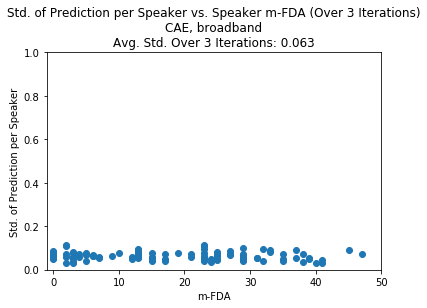

In [248]:
"""Takes standard deviation across multiple iterations of classification probabilites and then averaged over each utterance"""
spk_avg_var=np.zeros(100)
for i in range(100):
    spk_avg_var[i]=np.mean(np.std(sdAggResults[i],axis=0))
        
mean_var=np.mean(spk_avg_var)
        
plt.scatter(mfdas,spk_avg_var)
plt.xlim([-1,50])
plt.ylim([-.001,1])
plt.xlabel('m-FDA')
plt.ylabel('Std. of Prediction per Speaker')
plt.title('Std. of Prediction per Speaker vs. Speaker m-FDA (Over '+str(num_itrs)+' Iterations)\n'+mod+", "+rep+"\nAvg. Std. Over "+str(num_itrs)+" Iterations: "+ str(np.round(mean_var,3)))

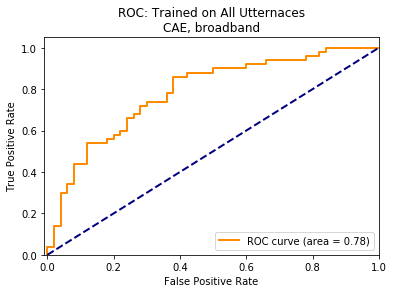

In [249]:
"""Looking at the ROC for a given classifier for a given patient and corresponding AUC."""
fpr=dict()
tpr=dict()
roc_auc=dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(np.array(y_test[:, i]), np.array(y_score[:, i]))
    roc_auc[i] = auc(fpr[i], tpr[i])

lw = 2
mgc=1
plt.plot(fpr[mgc], tpr[mgc], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[mgc])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC: Trained on All Utternaces\n'+mod+", "+rep)
plt.legend(loc="lower right")

Text(0.5, 1.0, 'm-FDA v. Difference in Classification Probability for 20th percentile "extreme" cases\n(m-FDAs <= 2 and >= 37)\nCAE, broadband\nOverall Test Acc: 0.9\n$\\rho$ = 0.777')

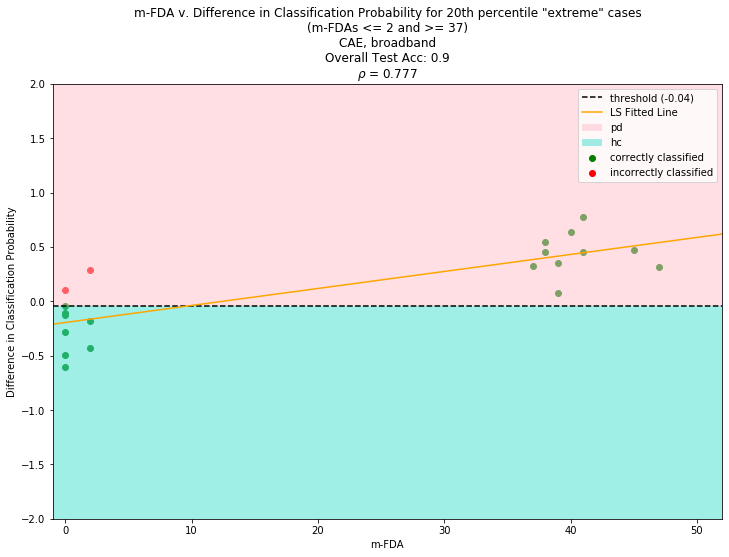

In [250]:
"""Looking at 2*n most 'extreme' cases in the database (n patients with smallest and n patients with largest m-fdas)"""

n=10

df=pd.read_csv(mfda_path+"metadata-Spanish_All.csv")
tail10_idx=np.sort(np.concatenate((df.nsmallest(n,['M-FDA']).index,df.nlargest(n,['M-FDA']).index)))
max_low=max(list(df['M-FDA'].nsmallest(n)))
min_high=min(list(df['M-FDA'].nlargest(n)))
xtr_mfdas=mfdas[tail10_idx]
xtr_y_score=y_score[tail10_idx,:]
xtr_y_test=y_test[tail10_idx,:]


"""Prediction based on difference between predicted class probs."""
plt.figure(figsize=(12,8))
poly=np.polyfit(xtr_mfdas, xtr_y_score[:,1]-xtr_y_score[:,0], 1)
x_lin_reg = range(-2, 53)
predict = np.poly1d(poly)
cor=stats.spearmanr(xtr_mfdas, xtr_y_score[:,1]-xtr_y_score[:,0])

correct_idx=np.concatenate((np.where((xtr_y_score[0:n,0]-xtr_y_score[0:n,1])<0)[0],np.where((xtr_y_score[n:,0]-xtr_y_score[n:,1])>0)[0]+n))
incorrect_idx=np.concatenate((np.where((xtr_y_score[0:n,0]-xtr_y_score[0:n,1])>0)[0],np.where((xtr_y_score[n:,0]-xtr_y_score[n:,1])<0)[0]+n))
plt.scatter(xtr_mfdas[correct_idx],(xtr_y_score[:,1]-xtr_y_score[:,0])[correct_idx],c='g' )
plt.scatter(xtr_mfdas[incorrect_idx],(xtr_y_score[:,1]-xtr_y_score[:,0])[incorrect_idx],c='r' )
plt.axhline(y=thresh, color='black', linestyle='--',label="threshold")
plt.plot(x_lin_reg,predict(x_lin_reg), color='orange')
plt.axhspan(thresh, 2, color='pink', alpha=0.5, lw=0)
plt.axhspan(-2, thresh, color='turquoise', alpha=0.5, lw=0)
plt.legend(['threshold ('+str(thresh)+')','LS Fitted Line', 'pd', 'hc', 'correctly classified', 'incorrectly classified'])
plt.xlim([-1,52])
plt.ylim([-2,2])
plt.xlabel('m-FDA')
plt.ylabel('Difference in Classification Probability')
plt.title('m-FDA v. Difference in Classification Probability for '+str(2*n)+'th percentile "extreme" cases\n(m-FDAs <= '+str(max_low)+' and >= '+str(min_high)+')\n'+mod+", "+rep+'\nOverall Test Acc: '+str(correct_idx.shape[0]/(2*n))+'\n'+r'$\rho$'+ " = "+str(np.round(cor[0],3)))



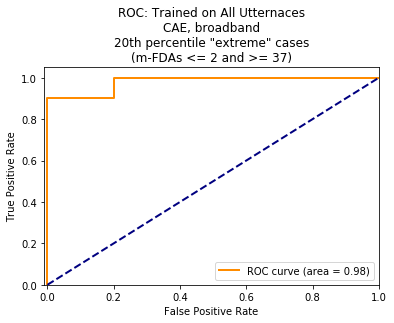

In [251]:
"""
Looking at the ROC for a given classifier for a given patient and corresponding AUC.
Specifically, looking at 2*n most 'extreme' cases in the database (n patients with smallest and n patients with largest m-fdas)

"""
fpr=dict()
tpr=dict()
roc_auc=dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(np.array(xtr_y_test[:, i]), np.array(xtr_y_score[:, i]))
    roc_auc[i] = auc(fpr[i], tpr[i])

lw = 2
mgc=1
plt.plot(fpr[mgc], tpr[mgc], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[mgc])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC: Trained on All Utternaces\n'+mod+", "+rep+'\n'+str(2*n)+'th percentile "extreme" cases\n(m-FDAs <= '+str(max_low)+' and >= '+str(min_high)+')')
plt.legend(loc="lower right")

Two sided T-test performed to determine if difference in results are significant.
Null Hypothesis: difference in probabilities output by the classifier for M/F speakers
with m-FDAs that are not significantly different is not significant.

M/F actual m-FDAS p-value: 0.532
M/F difference in probabilities: p-value: 7e-05


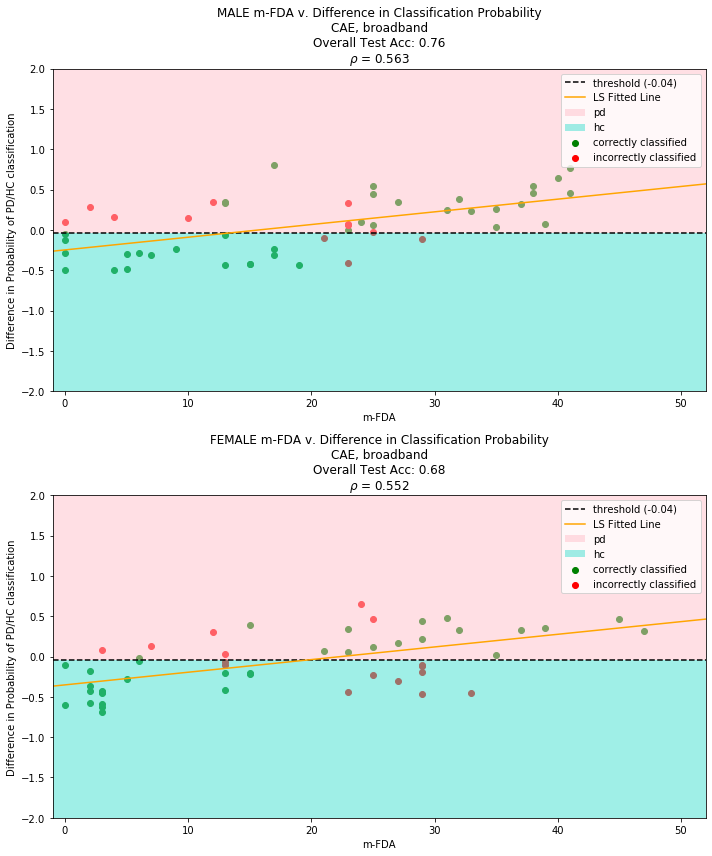

In [254]:
"""Gender based classification results (note that data used to train AEs skewed heavily male while PD data is evenly split M/F)"""
num_spks=100
mfda_path=PATH+"/pdSpanish/"
data=pd.read_csv(mfda_path+"metadata-Spanish_All.csv")
genders=data['gender'].values
mfdas=data['M-FDA'].values
m_idx=np.where(genders=='M')[0]
f_idx=np.where(genders=='F')[0]
m_mfdas=mfdas[m_idx]
f_mfdas=mfdas[f_idx]

m_test_acc=0
f_test_acc=0
m_y_score=np.zeros((50,2))
m_y_test=np.zeros((50,2))
f_y_score=np.zeros((50,2))
f_y_test=np.zeros((50,2))
m_res=np.zeros(300)
f_res=np.zeros(300)

m_count=0
f_count=0
for i in range(100):
        
    if i<50:
        if i in m_idx:
            m_res[6*m_count:(m_count+1)*6]= avgAggResults['pd'][i][:,0]
            m_y_score[m_count,:]=np.median(avgAggResults['pd'][i][:,0]),np.median(avgAggResults['pd'][i][:,1])
            m_y_test[m_count,:]=np.vstack((np.zeros(1),np.ones(1))).T
            spk_diff=m_y_score[m_count,1]-m_y_score[m_count,0]
            if spk_diff>thresh:
                m_test_acc+=1
            m_count+=1
        elif i in f_idx:
            f_res[6*f_count:(f_count+1)*6]= avgAggResults['pd'][i][:,0]
            f_y_score[f_count,:]=np.median(avgAggResults['pd'][i][:,0]),np.median(avgAggResults['pd'][i][:,1])
            f_y_test[f_count,:]=np.vstack((np.zeros(1),np.ones(1))).T
            spk_diff=f_y_score[f_count,1]-f_y_score[f_count,0]
            if spk_diff>thresh:
                f_test_acc+=1
            f_count+=1
    else:
        if i in m_idx:
            m_res[6*m_count:(m_count+1)*6]= avgAggResults['hc'][i][:,0]
            m_y_score[m_count,:]=np.median(avgAggResults['hc'][i][:,0]),np.median(avgAggResults['hc'][i][:,1])
            m_y_test[m_count,:]=np.vstack((np.ones(1),np.zeros(1))).T
            spk_diff=m_y_score[m_count,1]-m_y_score[m_count,0]
            if spk_diff<thresh:
                m_test_acc+=1
            m_count+=1
        elif i in f_idx:
            f_res[6*f_count:(f_count+1)*6]= avgAggResults['hc'][i][:,0]
            f_y_score[f_count,:]=np.median(avgAggResults['hc'][i][:,0]),np.median(avgAggResults['hc'][i][:,1])
            f_y_test[f_count,:]=np.vstack((np.ones(1),np.zeros(1))).T
            spk_diff=f_y_score[f_count,1]-f_y_score[f_count,0]
            if spk_diff<thresh:
                f_test_acc+=1
            f_count+=1


"""Prediction based on difference between predicted class probs."""

itr=0

print('Two sided T-test performed to determine if difference in results'+
      ' are significant.\nNull Hypothesis: difference in probabilities output by the classifier for M/F speakers'+
      '\nwith m-FDAs that are not significantly different is not significant.\n\nM/F actual m-FDAS p-value: '+
      str(np.round(stats.ttest_ind(m_mfdas,f_mfdas).pvalue,3))+
      '\nM/F difference in probabilities: p-value: '+
      str(np.round(stats.ttest_ind(m_res,f_res).pvalue,5)))

fig,(ax1,ax2)=plt.subplots(2,1,figsize=(10,12))
for ax,mfdas,y_score,y_test in zip([ax1,ax2],[m_mfdas,f_mfdas],[m_y_score,f_y_score],[m_y_test,f_y_test]):
    poly=np.polyfit(mfdas, y_score[:,1]-y_score[:,0], 1)
    x_lin_reg = range(-2, 53)
    predict = np.poly1d(poly)
    cor=stats.spearmanr(mfdas, y_score[:,1]-y_score[:,0])
    
    correct_idx=np.concatenate((np.where((y_score[0:25,0]-y_score[0:25,1])<0)[0],np.where((y_score[25:,0]-y_score[25:,1])>0)[0]+25))
    incorrect_idx=np.concatenate((np.where((y_score[0:25,0]-y_score[0:25,1])>0)[0],np.where((y_score[25:,0]-y_score[25:,1])<0)[0]+25))
    ax.scatter(mfdas[correct_idx],(y_score[:,1]-y_score[:,0])[correct_idx],c='g' )
    ax.scatter(mfdas[incorrect_idx],(y_score[:,1]-y_score[:,0])[incorrect_idx],c='r' )
    ax.axhline(y=thresh, color='black', linestyle='--',label="threshold")
    ax.plot(x_lin_reg,predict(x_lin_reg), color='orange')
    ax.axhspan(thresh, 2, color='pink', alpha=0.5, lw=0)
    ax.axhspan(-2, thresh, color='turquoise', alpha=0.5, lw=0)
    ax.legend(['threshold ('+str(thresh)+')','LS Fitted Line', 'pd', 'hc', 'correctly classified', 'incorrectly classified'])
    ax.set_xlim([-1,52])
    ax.set_ylim([-2,2])
    ax.set_xlabel('m-FDA')
    ax.set_ylabel('Difference in Probability of PD/HC classification')
    if itr==0:
        ax.set_title('MALE m-FDA v. Difference in Classification Probability\n'+mod+", "+rep+'\nOverall Test Acc: '+
                     str(correct_idx.shape[0]/50)+'\n'+r'$\rho$'+ " = "+str(np.round(cor[0],3)))
        itr+=1
    else:
        ax.set_title('FEMALE m-FDA v. Difference in Classification Probability\n'+mod+", "+rep+'\nOverall Test Acc: '+
                     str(correct_idx.shape[0]/50)+'\n'+r'$\rho$'+ " = "+str(np.round(cor[0],3)))
plt.tight_layout()




Text(33.0, 0.5, 'Actual')

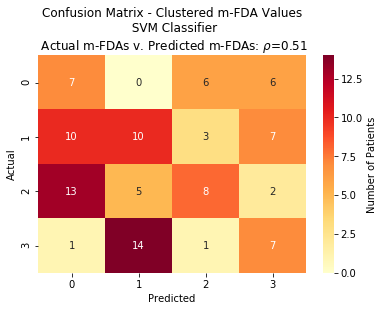

In [232]:
"""
Here we cluster the m-FDA scores (using KMeans clustering) into nc groups to see how the classifier and representation 
choice performs in prediciting the severity of the disease. The Spearman correlation is also reported in the figure title
and considers the actual m-FDAs and predicted m-FDAs (not clustered groups).
"""
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.cluster import KMeans
mfdas=pd.read_csv(mfda_path+"metadata-Spanish_All.csv")['M-FDA'].values

ncs=4
y_pred = KMeans(n_clusters=ncs, random_state=0).fit(np.reshape(mfdaResults,(-1,1))).labels_
y_act = KMeans(n_clusters=ncs, random_state=0).fit(np.reshape(mfdas,(-1,1))).labels_

cm = confusion_matrix(y_pred,y_act)
sns.heatmap(cm, annot=True, cmap='YlOrRd', cbar = True, xticklabels = np.arange(0,ncs), yticklabels = np.arange(0,ncs), cbar_kws={'label': 'Number of Patients'})
plt.title("Confusion Matrix - Clustered m-FDA Values\n SVM Classifier\n Actual m-FDAs v. Predicted m-FDAs: " +r'$\rho$'+ "="+str(np.round(stats.spearmanr(mfdas,mfdaResults),3)[0]))
plt.xlabel("Predicted")
plt.ylabel("Actual")


In [186]:
# """
# ADD choice number of pcs (>90% cumultive variance) 
# """
# fig,ax=plt.subplots(2,3,figsize=(15,8))

# for uItr,utter in enumerate(UTTERS):
#     row_itr=np.mod(uItr,2)
#     col_itr=np.mod(uItr,3)
#     pc_data=pd.read_pickle(PATH+"/pdSpanish/classResults/svm/params/"+mod+'_'+utter+'_'+rep+'_pc.pkl')
#     x=max(np.where(pc_data.loc['pc_var']['pataka']<90)[0])
#     y=pc_data.loc['pc_var']['pataka'][x]
    
#     ax[row_itr][col_itr].plot(pc_data.loc['pc_var']['pataka'])
#     ax[row_itr][col_itr].vlines(x, 0, y, linestyle="dashed")
#     ax[row_itr][col_itr].hlines(y, 0, x, linestyle="dashed")
#     ax[row_itr][col_itr].set_title("Cumulative Explained Variance per PC\n Min. # of Components Cumulating >90%: "+str(x))
#     ax[row_itr][col_itr].set_xlabel("# components")
#     ax[row_itr][col_itr].set_ylabel("cumulative explained variance")
#     ax[row_itr][col_itr].set_xlim([-.5, 100])
#     ax[row_itr][col_itr].set_ylim([min(pc_data.loc['pc_var']['pataka']), 100.5])
    
# plt.tight_layout()

In [187]:
# """
# Results reported per utterance.
# """
# num_itrs=list(results['pataka']['bin_class'].keys())[-1]+1
# y_scores=np.zeros((100*len(UTTERS)*num_itrs,2))
# y_tests=np.zeros((100*len(UTTERS)*num_itrs,2))

                  
# fig,ax=plt.subplots(2,3,figsize=(13, 6))
# for uItr,utter in enumerate(UTTERS):
#     y_score=np.zeros((100*num_itrs,2))
#     y_test=np.zeros((100*num_itrs,2))

#     for j in range(100):
#         for i in range(num_itrs):
#             y_score[i*100+j]+=results[utter]['bin_class'][i][j]
#             if j<50:
#                 y_test[i*100+j,:]=np.vstack((np.zeros(1),np.ones(1))).T
#             if j>=50:
#                 y_test[i*100+j,:]=np.vstack((np.ones(1),np.zeros(1))).T
    
#     y_scores[uItr*100*num_itrs:(uItr+1)*100*num_itrs]=y_score
#     y_tests[uItr*100*num_itrs:(uItr+1)*100*num_itrs]=y_test
#     fpr=dict()
#     tpr=dict()
#     roc_auc=dict()
#     for i in range(2):
#         fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
#         roc_auc[i] = auc(fpr[i], tpr[i])

#     lw = 2
#     mgc=1
#     row_itr=np.mod(uItr,2)
#     col_itr=np.mod(uItr,3)
#     ax[row_itr][col_itr].plot(fpr[mgc], tpr[mgc], color='darkorange',
#              lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[mgc])
#     ax[row_itr][col_itr].plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
#     ax[row_itr][col_itr].set_xlim([0.0, 1.0])
#     ax[row_itr][col_itr].set_ylim([0.0, 1.05])
#     ax[row_itr][col_itr].set_xlabel('False Positive Rate')
#     ax[row_itr][col_itr].set_ylabel('True Positive Rate')
#     ax[row_itr][col_itr].set_title('ROC: '+mod+", "+rep+", "+utter)
#     ax[row_itr][col_itr].legend(loc="lower right")
# #     plt.show()
# plt.tight_layout()


In [188]:
# """
# Overall results for independently trained models.
# """
# fpr=dict()
# tpr=dict()
# for i in range(2):
#     fpr[i], tpr[i], _ = roc_curve(np.array(y_tests[:, i]), np.array(y_scores[:, i]))
#     roc_auc[i] = auc(fpr[i], tpr[i])

# lw = 2
# mgc=1
# plt.plot(fpr[mgc], tpr[mgc], color='darkorange',
#          lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[mgc])
# plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC: Aggregating All Utternaces\n'+mod+", "+rep)
# plt.legend(loc="lower right")

In [189]:
# fig,ax=plt.subplots(2,3,figsize=(15,8))

# for uItr,utter in enumerate(UTTERS):
#     row_itr=np.mod(uItr,2)
#     col_itr=np.mod(uItr,3)
#     grid=joblib.load(PATH+"/pdSpanish/classResults/svm/params/"+mod+'_'+utter+'_'+rep+'Grid.pkl')
#     pvt = pd.pivot_table(pd.DataFrame(grid.cv_results_),values='mean_test_score', index='param_C',columns='param_gamma')
#     g = sns.heatmap(pvt,ax=ax[row_itr][col_itr])
#     g.set_ylabel("param 'C'")
#     g.set_xlabel("param 'Gamma'")
#     g.set_title('Heatmap: Random Grid Search for SVM params \n'+mod+", "+rep+", "+utter)
#     ylabels = ['{:,.3g}'.format(y) for y in pvt.index]
#     g.set_yticklabels(ylabels)
#     xlabels = ['{:,.3g}'.format(x) for x in pvt.columns]
#     g.set_xticklabels(xlabels)

# plt.tight_layout()

In [190]:
# UTTERS=['pataka','kakaka','pakata','papapa','petaka','tatata']

# grid=joblib.load(PATH+"/pdSpanish/classResults/svm/params/"+mod+'_'+rep+'aggGrid.pkl')
# print("The best parameters are: %s with a score of %0.2f"
#       % (grid.best_params_, grid.best_score_))

In [191]:
# grid=joblib.load(PATH+"/pdSpanish/classResults/svm/params/"+mod+'_'+rep+'aggGrid.pkl')
# pvt = pd.pivot_table(pd.DataFrame(grid.cv_results_),values='mean_test_score', index='param_C',columns='param_gamma')
# g = sns.heatmap(pvt)
# g.set_ylabel("param 'C'")
# g.set_xlabel("param 'Gamma'")
# g.set_title('Heatmap: Random Grid Search for SVM params \n'+mod+", "+rep)
# ylabels = ['{:,.3g}'.format(y) for y in pvt.index]
# g.set_yticklabels(ylabels)
# xlabels = ['{:,.3g}'.format(x) for x in pvt.columns]
# g.set_xticklabels(xlabels)
